In [125]:
pip install smalldiffusion

In [126]:
from inspect import stack

import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from smalldiffusion import (
    TimeInputMLP, ScheduleLogLinear, training_loop, samples,
    DatasaurusDozen, Swissroll
)
from traitlets import signature_has_traits


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot_batch(batch):
    batch = batch.cpu().numpy()
    plt.scatter(batch[:,0], batch[:,1], marker='.')

# 1. Infrastucture

Here, we build a model to un the code.

This is a 2-d dataset of mixed Gaussian.

In [127]:
N = 1000
dataset = (torch.randint(0,2,(N,1))*2-1)+torch.randn((N,2))*0.2

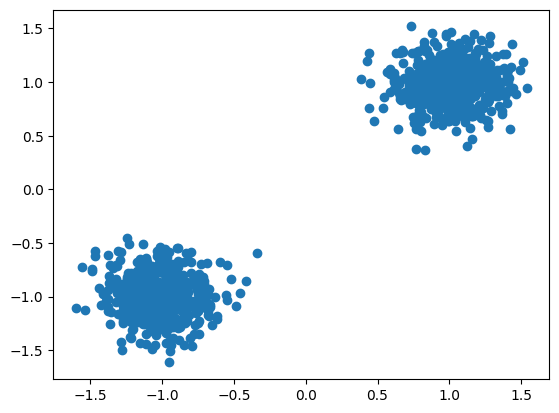

In [128]:
plt.scatter(dataset[:,0],dataset[:,1])

The following code is copied from https://github.com/yuanchenyang/smalldiffusion/blob/fc267d87e1efe552e16ecabc764bb9ab935434d9/src/smalldiffusion/diffusion.py but modified as a 2-d noise.

In [129]:
import math
from itertools import pairwise

import torch
import numpy as np
from accelerate import Accelerator
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from types import SimpleNamespace
from typing import Optional, Union, Tuple

class Schedule:
    '''Diffusion noise schedules parameterized by sigma'''
    def __init__(self, sigmas: torch.FloatTensor):
        self.sigmas = sigmas

    def __getitem__(self, i) -> torch.FloatTensor:
        return self.sigmas[i]

    def __len__(self) -> int:
        return len(self.sigmas)

    def sample_sigmas(self, steps: int) -> torch.FloatTensor:
        '''Called during sampling to get a decreasing sigma schedule with a
        specified number of sampling steps:
          - Spacing is "trailing" as in Table 2 of https://arxiv.org/abs/2305.08891
          - Includes initial and final sigmas
            i.e. len(schedule.sample_sigmas(steps)) == steps + 1
        '''
        indices = list((len(self) * (1 - np.arange(0, steps)/steps))
                       .round().astype(np.int64) - 1)
        return self[indices + [0]]

    def sample_batch(self, x0: torch.FloatTensor) -> torch.FloatTensor:
        '''Called during training to get a batch of randomly sampled sigma values
        '''
        batchsize = x0.shape[0]
        return self[torch.randint(len(self), (batchsize,))].to(x0)

def sigmas_from_betas(betas: torch.FloatTensor):
    return (1/torch.cumprod(1.0 - betas, dim=0) - 1).sqrt()

# Simple log-linear schedule works for training many diffusion models
class ScheduleLogLinear(Schedule):
    def __init__(self, N: int, sigma_min: float=0.02, sigma_max: float=10):
        super().__init__(torch.logspace(math.log10(sigma_min), math.log10(sigma_max), N))

# Default parameters recover schedule used in most diffusion models
class ScheduleDDPM(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        super().__init__(sigmas_from_betas(torch.linspace(beta_start, beta_end, N)))

# Default parameters recover schedule used in most latent diffusion models, e.g. Stable diffusion
class ScheduleLDM(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.00085, beta_end: float=0.012):
        super().__init__(sigmas_from_betas(torch.linspace(beta_start**0.5, beta_end**0.5, N)**2))

# Sigmoid schedule used in GeoDiff
class ScheduleSigmoid(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02):
        betas = torch.sigmoid(torch.linspace(-6, 6, N)) * (beta_end - beta_start) + beta_start
        super().__init__(sigmas_from_betas(betas))

# Cosine schedule used in Nichol and Dhariwal 2021
class ScheduleCosine(Schedule):
    def __init__(self, N: int=1000, beta_start: float=0.0001, beta_end: float=0.02, max_beta: float=0.999):
        alpha_bar = lambda t: np.cos((t + 0.008) / 1.008 * np.pi / 2) ** 2
        betas = [min(1 - alpha_bar((i+1)/N)/alpha_bar(i/N), max_beta)
                 for i in range(N)]
        super().__init__(sigmas_from_betas(torch.tensor(betas, dtype=torch.float32)))

'''
From now on, the part of training samples is changed
'''
# Given a batch of data
#   x0   : Either a data tensor or a tuple of (data, labels)
# Returns
#   eps  : i.i.d. normal with same shape as x0
#   sigma: uniformly sampled from schedule, with shape **same as the dataset**
def generate_train_sample(x0: Union[torch.FloatTensor, Tuple[torch.FloatTensor, torch.FloatTensor]],
                          schedule: Schedule, conditional: bool=False):
    cond = x0[1] if conditional else None
    x0   = x0[0] if conditional else x0
    sigmas = torch.as_tensor(schedule.sigmas, device=x0.device, dtype=x0.dtype)   # make once if reused
    idx  = torch.randint(len(sigmas), size=x0.shape, device=x0.device)
    sigma = sigmas[idx]
    # while len(sigma.shape) < len(x0.shape):
    #     sigma = sigma.unsqueeze(-1)
    eps = torch.randn_like(x0)
    return x0, sigma, eps, cond

# Model objects
# Always called with (x, sigma):
#   If x.shape == [B, D1, ..., Dk], sigma.shape == [] or [B, 1, ..., 1].
#   If sigma.shape == [], model will be called with the same sigma for each x0
#   Otherwise, x[i] will be paired with sigma[i] when calling model
# Have a `rand_input` method for generating random xt during sampling

def training_loop(loader      : DataLoader,
                  model       : nn.Module,
                  schedule    : Schedule,
                  accelerator : Optional[Accelerator] = None,
                  epochs      : int = 10000,
                  lr          : float = 1e-3,
                  conditional : bool = False):
    accelerator = accelerator or Accelerator()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model, optimizer, loader = accelerator.prepare(model, optimizer, loader)
    for _ in (pbar := tqdm(range(epochs))):
        for x0 in loader:
            model.train()
            optimizer.zero_grad()
            x0, sigma, eps, cond = generate_train_sample(x0, schedule, conditional)
            loss = model.get_loss(x0, sigma, eps, cond=cond)
            yield SimpleNamespace(**locals()) # For extracting training statistics
            accelerator.backward(loss)
            optimizer.step()


Now we use the codes of https://github.com/yuanchenyang/smalldiffusion/blob/main/src/smalldiffusion/model.py to build a tiny model.

Please note that we have changed the variables. Our model is
$$X(t)=\sqrt{\frac{v(t)}{v(t)+1}}X_0\mathrm dt+\sqrt\frac{1}{v(t)+1}Z,$$

Where $Z$ is $\mathcal N(0,1)$. Because of the template, I make `sigma` as $v$ here.

In [130]:
import math
import torch
import torch.nn.functional as F
from torch import nn
from einops import rearrange, repeat
from itertools import pairwise


## Basic functions used by all models

class ModelMixin:
    def rand_input(self, batchsize):
        assert hasattr(self, 'input_dims'), 'Model must have "input_dims" attribute!'
        return torch.randn((batchsize,) + self.input_dims)

    # Currently predicts eps, override following methods to predict, for example, x0
    def get_loss(self, x0, sigma, eps, cond=None, loss=nn.MSELoss):
        return loss()(eps, self(x0 + sigma * eps, sigma, cond=cond))

    def predict_eps(self, x, sigma, cond=None):
        return self(x, sigma, cond=cond)

    def predict_eps_cfg(self, x, sigma, cond, cfg_scale):
        if cond is None or cfg_scale == 0:
            return self.predict_eps(x, sigma, cond=cond)
        assert sigma.shape == tuple(), 'CFG sampling only supports singleton sigma!'
        uncond = torch.full_like(cond, self.cond_embed.null_cond) # (B,)
        eps_cond, eps_uncond = self.predict_eps(                  # (B,), (B,)
            torch.cat([x, x]), sigma, torch.cat([cond, uncond])   # (2B,)
        ).chunk(2)
        return eps_cond + cfg_scale * (eps_cond - eps_uncond)

def get_sigma_embeds(batches, sigma, scaling_factor=0.5, log_scale=True):
    if sigma.shape == torch.Size([]):
        sigma = sigma.unsqueeze(0).repeat(batches)
    else:
        assert sigma.shape == (batches,), 'sigma.shape == [] or [batches]!'
    if log_scale:
        sigma = torch.log(sigma)
    s = sigma.unsqueeze(1) * scaling_factor
    return torch.cat([torch.sin(s), torch.cos(s)], dim=1)

# We allow three types of sigma here.
# 1. The scalar.
# 2. High dimensional sigmas, and the sigma is the same as dataset. (remember! x0.shape[1] is batchsize.)
# 3. High dimensional sigmas and the sigma is the whole dataset.
# All of them are torch.tensor objects.

def get_sigma_embeds_hi_dim(x0, sigma, scaling_factor=0.25, log_scale=True):
    if sigma.shape == torch.Size([]):
        sigma = sigma.unsqueeze(0).repeat(x0.shape)
    elif sigma.shape == x0.shape[1:]:
        sigma = sigma.unsqueeze(0).repeat((x0.shape[0],)+(1,)*(len(x0.shape)-1))
    else:
        assert sigma.shape == x0.shape, 'sigma.shape == [] or [batches]!'
    if log_scale:
        sigma = torch.log(sigma)
    s = sigma * scaling_factor
    sin_s = torch.sin(s)
    cos_s = torch.cos(s)
    stacked_s = torch.stack([sin_s, cos_s], dim=1)
    result = stacked_s.permute(0, 2, 1).reshape(s.shape[0], 2 * s.shape[1])
    return result

## Simple MLP for toy examples, modified a bit from the original file.
## This is meant to predict x0 though.

class HighDimNoise(nn.Module, ModelMixin):
    sigma_dim = 2
    def __init__(self, dim=2, output_dim=None, hidden_dims=(16,128,256,128,16)):
        super().__init__()
        layers = []
        for in_dim, out_dim in pairwise((dim*3,) + hidden_dims):
            layers.extend([nn.Linear(in_dim, out_dim), nn.GELU()])
        layers.append(nn.Linear(hidden_dims[-1], output_dim or dim))

        self.net = nn.Sequential(*layers)
        self.input_dims = (dim,)

    def forward(self, x, sigma, cond=None):
        # x     shape: b x dim
        # sigma shape: b x dim
        sigma_embeds = get_sigma_embeds_hi_dim(x, sigma) # shape: b x (2*dim)
        nn_input = torch.cat([x, sigma_embeds], dim=1)   # shape: b x (3*dim)
        return self.net(nn_input)

    def get_loss(self, x0, sigma, eps=None, cond=None, loss=nn.MSELoss):
        # print(x0.shape, sigma.shape, eps.shape)
        # Please be notice that: in THIS case specifically, x0 and sigma ARE the same shape! NO NEED TO UNSQUEEZE!
        noise = 1/(1+sigma)
        alpha = 1-noise
        if eps is None:
            eps = torch.randn_like(x0)

        return loss()(x0, self(torch.sqrt(alpha) * x0 + torch.sqrt(noise) * eps, sigma, cond=cond))

    def predict_x0(self, x, sigma, cond=None):
        x0_hat = self(x, sigma, cond=cond)
        return x0_hat

    def predict_eps(self, x, sigma, cond=None):
        noise = 1/(1+sigma)
        alpha = 1-noise
        x0_hat = self(x, sigma, cond=cond)
        return (x - x0_hat * torch.sqrt(alpha))/(torch.sqrt(noise) + 1e-8)


Now we train!

100%|██████████| 15000/15000 [06:14<00:00, 40.00it/s]


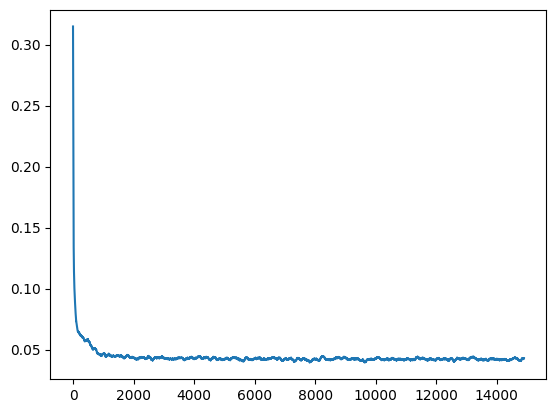

In [131]:
loader = DataLoader(dataset, batch_size=2048)
model = HighDimNoise(hidden_dims=(16,128,128,128,128,16))
schedule = ScheduleLogLinear(N=200, sigma_min=0.05, sigma_max=1e6)
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]
plt.plot(moving_average(losses, 100))
plt.show()

In [132]:
trainer

<generator object training_loop at 0x790b04eb1d20>

Now we first do a sampling algorithm. We use https://github.com/yuanchenyang/smalldiffusion/blob/fc267d87e1efe552e16ecabc764bb9ab935434d9/src/smalldiffusion/diffusion.py code.

To make the theory clear, we do some calculation. Our model is $X(t)=\sqrt{\frac{v(t)}{v(t)+1}}X_0\mathrm dt+\sqrt\frac{1}{v(t)+1}Z$, so the diffusion process is
$$\mathrm dX(t)=\frac{1}{2}\cdot\frac{v'(t)}{v(t)(1+v(t))} X(t)\mathrm{d}t+\frac{\sqrt{-v'(t)}}{\sqrt{v(t)(1+v(t))}}\mathrm dB_t..$$

Here, please be noticed that $v(t)$ is **decreasing** when the noise is larger.

Therefore, the reverse-time diffusion process is (by https://arxiv.org/pdf/2011.13456)
$$\mathrm dX(t)=\frac{v'(t)}{v(t)(1+v(t))}\left(\frac{1}{2} X(t)+\nabla_x\log p_t(X_t)\right)\mathrm{d}t+\frac{\sqrt{-v'(t)}}{\sqrt{v(t)(1+v(t))}}\mathrm dB_t.$$

Then, by Tweedie's formula, we have
$$\frac{\partial}{\partial X}\log p_t(X) =\frac{\sqrt{\frac{v(t)}{v(t)+1}}\mathbb E[X(0)|v(t),X(t)]-X(t)}{1/(1+v(t))}.$$

Therefore, plugging the Tweedie's formula, we have
\begin{align}
\mathrm dX(t)=&\frac{v'(t)}{v(t)(1+v(t))}\left(\frac{1}{2} X(t)+\frac{\sqrt{\frac{v(t)}{v(t)+1}}\mathbb E[X(0)|v(t),X(t)]-X(t)}{1/(1+v(t))}\right)\mathrm{d}t+\frac{\sqrt{-v'(t)}}{\sqrt{v(t)(1+v(t))}}\mathrm dB_t\\
=&-\frac{v'(t)}{v(t)(1+v(t))}\frac{1+2v(t)}{2}\mathrm dt+\left(\frac{v'(t)}{\sqrt{{v(t)}{(v(t)+1)}}}\mathbb E[X(0)|v(t),X(t)]\right)\mathrm{d}t+\frac{\sqrt{-v'(t)}}{\sqrt{v(t)(1+v(t))}}\mathrm dB_t
\end{align}

Now we derive the denoising step. We want to calculate $A, B, C$ for the DDPM-like sampling step:
$$X_{v'} = AX_v + B\hat X_0 + C Z.$$

We have
$$A = \exp\left(\int_{v}^{v'}-\frac{\mathrm du}{u(1+u)}\frac{1+2u}{2}\right)=\sqrt\frac{v(v+1)}{v'(v'+1)}.$$
$$B = \int_{v}^{v'} \frac{1}{\sqrt{u(1+u)}}\exp\left(\int_{u}^{v'}-\frac{\mathrm dt}{t(1+t)}\frac{1+2t}{2}\mathrm dt\right){\mathrm du}=\int_{v}^{v'} \frac{1}{{u(1+u)}}\sqrt\frac{u(u+1)}{v'(v'+1)}{\mathrm du}=\frac{v'-v}{\sqrt{v'(v'+1)}}.$$
$$C^2 = \int_{v}^{v'} \frac{\mathrm du}{u(1+u)}\exp\left(\int_{u}^{v'}-\frac{\mathrm dt}{t(1+t)}\frac{1+2t}{2}\mathrm dt\right)^2=\int_{v}^{v'} \frac{\mathrm du}{u(1+u)}\frac{u(u+1)}{v'(v'+1)}=\frac{v'-v}{{v'(v'+1)}}.$$

Also, we can use another way to calculate $A,B,C$. We can calculate that $X_{v'}\sim\mathcal N(\sqrt{\frac{v'}{v'+1}}X_0,\frac{1}{v'+1})$ and also $X_v|X_{v'}\sim \mathcal N(\sqrt\frac{(v'+1)v}{v'(v+1)}X_{v'}, \frac{v'-v}{v'(v+1)})$.

Notice that $p(X_{v}|X_{v'},X_0)=p(X_{v}|X_{v'})$ Therefore, we can calculate that the conditional distribution of $X_{v'}|X_0,X_v$ is (by Bayes rule) directly proportional to
$$p(X_{v'}|X_0)p(X_{v}|X_{v'})=\exp\left(\frac{(v'+1)}{2}\|X_{v'}-\sqrt\frac{v'}{v'+1}X_{0}\|^2+\frac{v'(v+1)}{2(v'-v)}\|X_{v}-\sqrt\frac{(v'+1)v}{v'(v+1)}X_{v'}\|^2\right)$$

So, collecting the terms, we can calculate that the distribution is
$$\mathcal N(\sqrt\frac{v(v+1)}{v'(v'+1)}X_v+\frac{v'-v}{\sqrt{v'(v'+1)}}X_0, \frac{v'-v}{v'(1+v')})$$

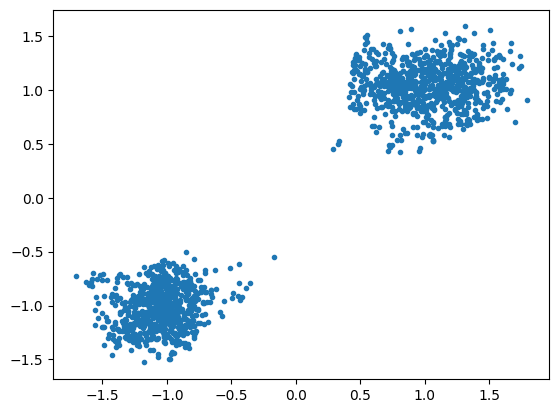

In [133]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

@torch.no_grad()
def samples(model      : nn.Module,
            sigmas     : torch.FloatTensor, # Iterable with N+1 values for N sampling steps
            gam        : float = 1.,        # Suggested to use gam >= 1
            mu         : float = 0.,        # Requires mu in [0, 1)
            cfg_scale  : int = 0.,          # 0 means no classifier-free guidance
            batchsize  : int = 1,
            xt         : Optional[torch.FloatTensor] = None,
            cond       : Optional[torch.Tensor] = None,
            accelerator: Optional[Accelerator] = None):
    model.eval()
    accelerator = accelerator or Accelerator()
    xt = model.rand_input(batchsize).to(accelerator.device) if xt is None else xt
    if cond is not None:
        assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
        cond = cond.to(xt.device)
    x0 = None
    for i, (sig_prev, sig) in enumerate(pairwise(sigmas)):
        x0_prev, x0 = x0, model.predict_x0(xt, sig.to(xt), cond)
        x0_av = x0 * gam + x0_prev * (1-gam)  if i > 0 else x0
        xt_coef = torch.sqrt((sig_prev*(sig_prev+1)) / (sig*(sig+1)))
        x0_coef = (sig - sig_prev)/torch.sqrt(sig*(sig+1))
        eta = torch.sqrt(sig - sig_prev)/torch.sqrt(sig*(sig+1))
        xt = xt * xt_coef + x0_av * x0_coef + eta * model.rand_input(xt.shape[0]).to(xt)
        yield xt

*xts, x0 = samples(model, schedule.sample_sigmas(20).flip(0), batchsize=1500, gam=1, mu=0)
plot_batch(x0)

# 2. Calculate the losses

Consider the losses of each pixel. We first code for the infrastructure of calculating the losses.

In [134]:
# First calculate the loss of dataset or our model
# x0 are the original dataset,
# sigmas are either scalar (all of same noise) or a tensor same as each data in x0.

def get_loss_grad(model: nn.Module,
             x0: torch.FloatTensor,
             sigmas: torch.FloatTensor):
    sigma_grad = sigmas.detach().clone().requires_grad_(True)
    loss = model.get_loss(x0, sigma_grad)
    return torch.autograd.grad(loss, sigma_grad)

In [135]:
grad = torch.tensor([get_loss_grad(model, x0, sigma) for sigma in schedule.sigmas])
grad = grad.squeeze()

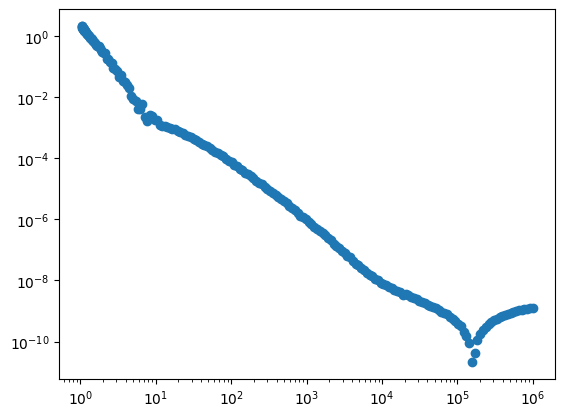

In [136]:
import matplotlib.pyplot as plt
plt.scatter((1+schedule.sigmas).numpy(), abs(grad.numpy()))
plt.xscale("log")
plt.yscale("log")
plt.show()

In [137]:
loss = torch.tensor([model.get_loss(x0, sigma) for sigma in schedule.sigmas])
loss = loss.detach().squeeze()

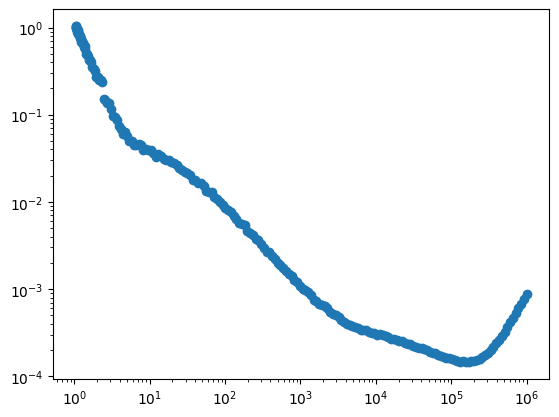

In [138]:
import matplotlib.pyplot as plt
plt.scatter(((1+schedule.sigmas)).numpy(), abs(loss.numpy()))
plt.xscale("log")
plt.yscale("log")
plt.show()

Therefore, we can roughly see that the loss is of scale $1/(1+v_i)$ and also the gradiant of loss is of scale $1/(1+v_1)^2$, which is reasonable.

In [139]:
# First calculate the loss of dataset or our model
# x0 are the original dataset,
# sigmas are either scalar (all of same noise) or a tensor same as each data in x0.

def get_loss_hi_dim(model: nn.Module,
             x0: torch.FloatTensor,
             sigmas: torch.FloatTensor):
    sigma_grad = sigmas.detach().clone().requires_grad_(True)
    eps = torch.randn_like(x0)
    alpha = sigma_grad/(1+sigma_grad)
    noise = 1/(1+sigma_grad)
    x0_hat = model(torch.sqrt(alpha) * x0 + torch.sqrt(noise) * eps, sigma_grad)
    return torch.mean((x0_hat-x0)**2, dim=0)

def get_loss_hi_dim_grad(model: nn.Module,
             x0: torch.FloatTensor,
             sigmas: torch.FloatTensor):
    sigma_grad = sigmas.detach().clone().requires_grad_(True)
    def loss(sigmas):
        eps = torch.randn_like(x0)
        alpha = sigmas/(1+sigmas)
        noise = 1/(1+sigmas)
        x0_hat = model(torch.sqrt(alpha) * x0 + torch.sqrt(noise) * eps, sigmas)
        return torch.mean((x0_hat-x0)**2, dim=0)
    return torch.autograd.functional.jacobian(loss, sigma_grad)

Now we test some data.

In [140]:
sigma_grad = torch.tensor([9.0,99.0], requires_grad=True)

In [141]:
get_loss_hi_dim_grad(model, x0, sigma_grad)

tensor([[-1.8905e-03,  2.9584e-06],
        [-7.5889e-06, -6.5319e-05]])

In [142]:
get_loss_hi_dim(model, x0, sigma_grad)

tensor([0.0478, 0.0088], grad_fn=<MeanBackward1>)

In [143]:
M = get_loss_hi_dim_grad(model, x0, sigma_grad)
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[-0.1869,  0.0033],
        [-0.0059, -0.6792]], grad_fn=<MulBackward0>)

In [144]:
# Try another set
sigma_grad = torch.tensor([4.0,9.0], requires_grad=True)
get_loss_hi_dim_grad(model, x0, sigma_grad), get_loss_hi_dim(model, x0, sigma_grad)

(tensor([[-0.0044, -0.0009],
         [-0.0011, -0.0016]]),
 tensor([0.0566, 0.0309], grad_fn=<MeanBackward1>))

In [145]:
M = get_loss_hi_dim_grad(model, x0, sigma_grad)
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[-0.0827, -0.0118],
        [-0.0150, -0.1182]], grad_fn=<MulBackward0>)

So aside from the scales of the noises and gradients, we can also observe (roughly) that the Jacobian matrix (gradiant) of the error with respect to the SNR's ($v_i$'s) is roughly diagonal.

What about 3d-data?

In [146]:
N = 2000           # number of samples
radius = 2.0       # L1 radius |x|_1 = 2
noise_std = 0.1    # sqrt(0.01) -> N(0, 0.01 I)

dirichlet = torch.distributions.Dirichlet(torch.ones(3))
abs_vals = dirichlet.sample((N,))                  # shape: (N, 3), rows sum to 1

signs = torch.randint(0, 2, (N, 3), dtype=torch.float32) * 2 - 1  # in {-1, +1}

x = radius * signs * abs_vals                      # |x|_1 = radius exactly (up to fp roundoff)

dataset_3d = x + noise_std * torch.randn_like(x)

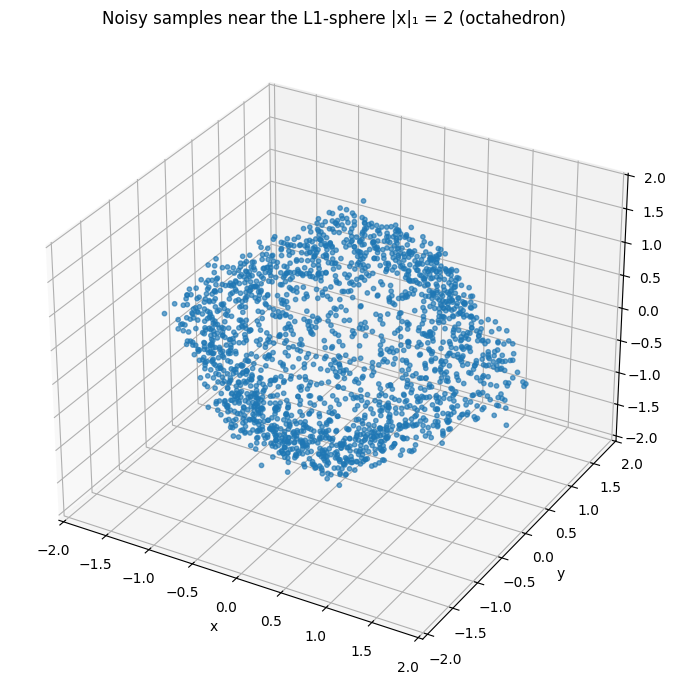

In [147]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D projection in some envs)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset_3d[:, 0].numpy(),
           dataset_3d[:, 1].numpy(),
           dataset_3d[:, 2].numpy(),
           s=10, alpha=0.65)

ax.set_title("Noisy samples near the L1-sphere |x|₁ = 2 (octahedron)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

# Make axes roughly equal-scale
mins = dataset_3d.min(dim=0).values.numpy()
maxs = dataset_3d.max(dim=0).values.numpy()
centers = (mins + maxs) / 2
max_range = (maxs - mins).max() / 2
ax.set_xlim(centers[0] - max_range, centers[0] + max_range)
ax.set_ylim(centers[1] - max_range, centers[1] + max_range)
ax.set_zlim(centers[2] - max_range, centers[2] + max_range)

plt.tight_layout()
plt.show()

100%|██████████| 15000/15000 [10:11<00:00, 24.54it/s]


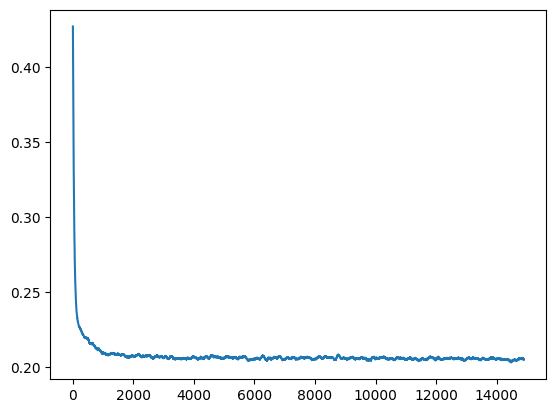

In [148]:
loader_3d = DataLoader(dataset_3d, batch_size=2048)
model_3d = HighDimNoise(dim = 3, hidden_dims=(16,128,128,128,128,16))
schedule_3d = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=4e4)
trainer_3d = training_loop(loader_3d, model_3d, schedule_3d, epochs=15000, lr=1e-3)
losses_3d = [ns.loss.item() for ns in trainer_3d]
plt.plot(moving_average(losses_3d, 100))
plt.show()

In [149]:
*xts, x0 = samples(model_3d, schedule_3d.sample_sigmas(20).flip(0), batchsize=1500, gam=1, mu=0)
sigma_grad = torch.tensor([0.1,9.0,999.0], requires_grad=True)
M = get_loss_hi_dim_grad(model_3d, x0, sigma_grad)
M

tensor([[-7.2819e-01, -1.1887e-03,  1.0869e-07],
        [-2.6342e-03, -7.6738e-03, -4.4738e-09],
        [ 1.0929e-04, -5.4141e-06, -9.3678e-07]])

In [150]:
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[-8.8111e-01, -1.3075e-02,  1.1956e-04],
        [-2.8976e-02, -7.6738e-01, -4.4738e-05],
        [ 1.2022e-01, -5.4141e-02, -9.3678e-01]], grad_fn=<MulBackward0>)

In [151]:
*xts, x0 = samples(model_3d, schedule_3d.sample_sigmas(20).flip(0), batchsize=1500, gam=1, mu=0)
sigma_grad = torch.tensor([9.0,99.0,999.0], requires_grad=True)
M = get_loss_hi_dim_grad(model_3d, x0, sigma_grad)
M

tensor([[-3.4722e-03, -4.8211e-05, -6.9221e-07],
        [-6.5108e-05, -7.9400e-05,  4.0104e-08],
        [-5.1251e-06,  4.7081e-08, -9.7190e-07]])

In [152]:
(sigma_grad.unsqueeze(1)+1)*M*(sigma_grad.unsqueeze(0)+1)

tensor([[-0.3472, -0.0482, -0.0069],
        [-0.0651, -0.7940,  0.0040],
        [-0.0513,  0.0047, -0.9719]], grad_fn=<MulBackward0>)

Therefore, we assume that the Jacobian of error $\nabla E(v)$ satiafy $\mathrm{diag}(v)\cdot \nabla E(v) \cdot\mathrm{diag}(v)$ is spectrally bounded.

# 3. Algorithm

We now implement the algorithm. We will use a gradient-based algorithm to do this.

Fisrt, we intialize the schedule as uniform

We now use a different dataset. This is an product measure of triangle distribution and a Gaussian.

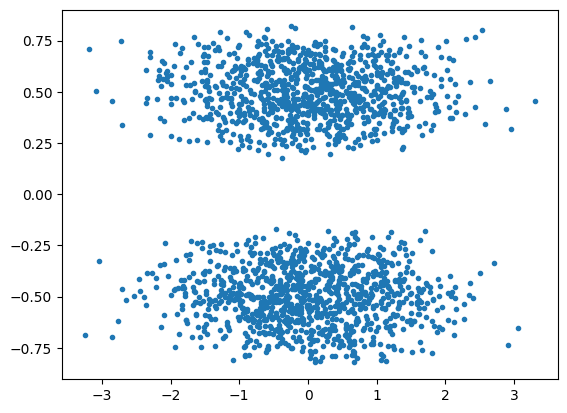

In [153]:
N = 2000
normal = torch.randn(N)
triangle = (torch.rand(N)-torch.rand(N))/3+torch.randint(0, 2,size = (N,))-0.5
dataset = torch.stack([normal, triangle], 1)
plot_batch(dataset)

Now we train the data

100%|██████████| 15000/15000 [10:05<00:00, 24.77it/s]


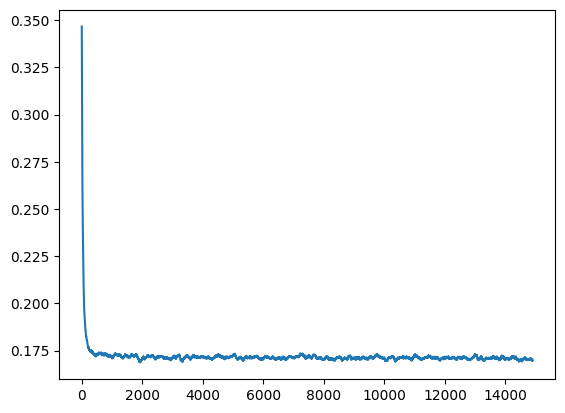

In [154]:
loader = DataLoader(dataset, batch_size=2048)
model = HighDimNoise(hidden_dims=(16,128,128,128,128,16))
schedule = ScheduleLogLinear(N=100, sigma_min=0.05, sigma_max=1e4)
trainer = training_loop(loader, model, schedule, epochs=15000, lr=1e-3)
losses = [ns.loss.item() for ns in trainer]
plt.plot(moving_average(losses, 100))
plt.show()

Now we calculate the loss and the gradient. Let these schedules (vector!) $v_i$, after taking the gradient, is $(e^{s_i[1]},\dots,e^{s_i[k]})$. The loss is given by the formula:
$$\mathcal E=\sum_{i=1}^{T}\langle E(v_i), v_{i-1}-v_i\rangle=\sum_{i=1}^{T-}\langle E(e^{s_i}), e^{s_{i-1}}-e^{s_i}\rangle.$$

Where $E$ is the function form $\mathbb R^n\to\mathbb R^n$

In [155]:
x0 = dataset
log_sigma = torch.stack([torch.log(schedule.sigmas),torch.log(schedule.sigmas)],1)
log_sigma.requires_grad_(True)
def get_total_loss(model: nn.Module,
                   x0: torch.FloatTensor,
                   log_sigma: torch.FloatTensor):
    assert log_sigma.requires_grad == True
    E = 0
    N = log_sigma.shape[0]
    sigmas = torch.exp(log_sigma)
    # print(sigmas)
    alphas = sigmas/(1+sigmas)
    noises = 1/(1+sigmas)
    for i in range(1,N):
        eps = torch.randn_like(x0)
        x0_hat = model(torch.sqrt(alphas[i]) * x0 + torch.sqrt(noises[i]) * eps, sigmas[i])
        Error = torch.mean((x0_hat-x0)**2, dim=0)
        E += torch.dot(Error, sigmas[i]-sigmas[i-1])
    return E

In [156]:
get_total_loss(model, x0, log_sigma)

tensor(28.5289, grad_fn=<AddBackward0>)

In [157]:
E=get_total_loss(model, x0, log_sigma)
E.backward()
log_sigma.grad, log_sigma.grad.shape

(tensor([[-4.6262e-02, -1.3222e-02],
         [-9.6542e-04,  5.4452e-05],
         [ 1.4012e-04,  1.8095e-04],
         [ 2.8941e-04, -2.6423e-05],
         [-9.9478e-04, -5.9787e-05],
         [ 2.5483e-03,  4.3805e-05],
         [-1.7207e-03,  5.5333e-05],
         [-2.0560e-03, -3.9880e-04],
         [ 4.5858e-03,  5.0507e-04],
         [-2.5038e-05, -4.6557e-04],
         [-4.0663e-03,  2.1390e-04],
         [ 7.5122e-03, -4.7577e-04],
         [-8.0615e-03,  1.2411e-05],
         [ 1.0118e-02,  1.2704e-03],
         [-1.5781e-03, -1.7720e-03],
         [-9.4362e-03,  1.5366e-03],
         [ 8.8608e-03, -2.7578e-03],
         [ 9.3854e-04,  2.8840e-03],
         [-3.8578e-03,  1.1036e-03],
         [-1.0079e-02,  2.4804e-04],
         [ 1.1093e-02,  3.8857e-03],
         [ 1.1663e-03,  4.6072e-04],
         [ 2.3291e-02, -3.8358e-03],
         [-1.3732e-02,  1.4327e-03],
         [-5.6481e-03, -2.7633e-03],
         [-1.3198e-02, -2.8561e-03],
         [ 3.3630e-02,  4.3232e-03],
 

We ignore the first and the last one.

In [158]:
def gradient(model: nn.Module,
             x0: torch.FloatTensor,
             log_sigma: torch.FloatTensor,
             learning_rate: float,
             parity: int,
             grad = None):
    E = get_total_loss(model, x0, log_sigma)
    E.backward()
    if grad is None:
        grad = log_sigma.grad
    n = log_sigma.shape[0]
    if parity == 1:
        index = torch.arange(1, n-1, 2)
    else:
        index = torch.arange(2, n-1, 2)
    updated = log_sigma.detach().clone()
    grad = grad[index]
    norm_grad = torch.clamp(grad.norm(dim=1, keepdim=True), min = 1)
    grad = grad / norm_grad
    clamped_grad = torch.zeros_like(grad)
    diff_prev = log_sigma[index-1] - log_sigma[index]
    diff_next = log_sigma[index+1] - log_sigma[index]

    mask_pos = grad>0
    mask_neg = grad<0

    clamped_grad[mask_pos] = - diff_prev[mask_pos] / grad[mask_pos]
    clamped_grad[mask_neg] = - diff_next[mask_neg] / grad[mask_neg]
    clamped_grad_final = clamped_grad.min(dim = 1).values
    clamped_grad_final = torch.clamp(clamped_grad_final, min=0, max=learning_rate)

    updated[index] = log_sigma[index] - grad*(clamped_grad_final.unsqueeze(1))
    updated = updated.detach().clone()
    updated.requires_grad_(True)
    return updated

Now we try the algorithm!

In [159]:
x0 = dataset
log_sigma_init = torch.stack([torch.log(schedule.sigmas),torch.log(schedule.sigmas)],1)
log_sigma_init.requires_grad_(True)
loss = [get_total_loss(model, x0, log_sigma_init).item()]
epoch = 200
learning_rate = 0.2

In [160]:
log_sigma = log_sigma_init.detach().clone()
log_sigma.requires_grad_(True)
for i in range(1,epoch+1):
  if i%10 == 0:
    print(f"{i} / {epoch}")
  log_sigma = gradient(model, x0, log_sigma, learning_rate, i%2)
  loss += [get_total_loss(model, x0, log_sigma).item()]

10 / 200
20 / 200
30 / 200
40 / 200
50 / 200
60 / 200
70 / 200
80 / 200
90 / 200
100 / 200
110 / 200
120 / 200
130 / 200
140 / 200
150 / 200
160 / 200
170 / 200
180 / 200
190 / 200
200 / 200


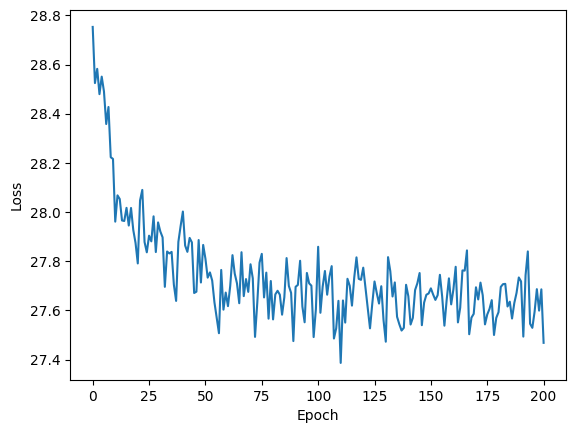

In [161]:
from matplotlib import pyplot as plt
y = loss
x = list(range(epoch+1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(x,y)

In [162]:
final_loss_sigma = log_sigma.detach().clone()
final_loss_sigma, log_sigma_init

(tensor([[-2.9957, -2.9957],
         [-2.8705, -2.8725],
         [-2.7500, -2.7489],
         [-2.6267, -2.6271],
         [-2.5049, -2.5019],
         [-2.3770, -2.3798],
         [-2.2574, -2.2560],
         [-2.1270, -2.1326],
         [-2.0279, -2.0097],
         [-1.8846, -1.8897],
         [-1.7753, -1.7646],
         [-1.6420, -1.6433],
         [-1.5272, -1.5173],
         [-1.4535, -1.3952],
         [-1.1641, -1.2673],
         [-1.1641, -1.1488],
         [-1.1641, -1.0302],
         [-0.8306, -0.9033],
         [-0.8306, -0.7783],
         [-0.6056, -0.6668],
         [-0.6056, -0.5298],
         [-0.3831, -0.4056],
         [-0.3831, -0.2824],
         [-0.0999, -0.1515],
         [-0.0999, -0.0428],
         [ 0.2498,  0.0849],
         [ 0.2498,  0.2084],
         [ 0.2498,  0.3435],
         [ 0.4953,  0.4488],
         [ 0.4953,  0.5982],
         [ 0.7838,  0.6873],
         [ 0.7838,  0.8278],
         [ 0.9896,  0.9610],
         [ 0.9896,  1.0425],
         [ 1.2

Now we compare the generated samples.

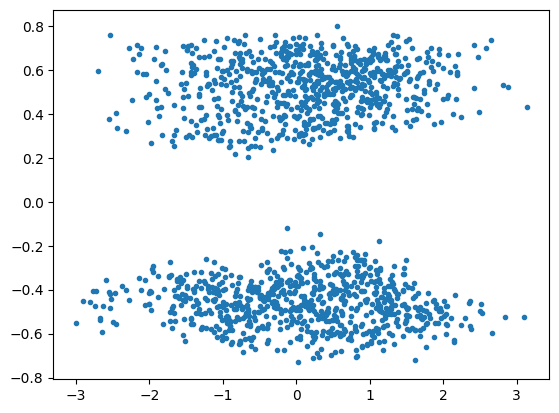

In [166]:
*xts, x01 = samples(model, torch.exp(log_sigma_init), batchsize=1500, gam=1, mu=0)
plot_batch(x01)

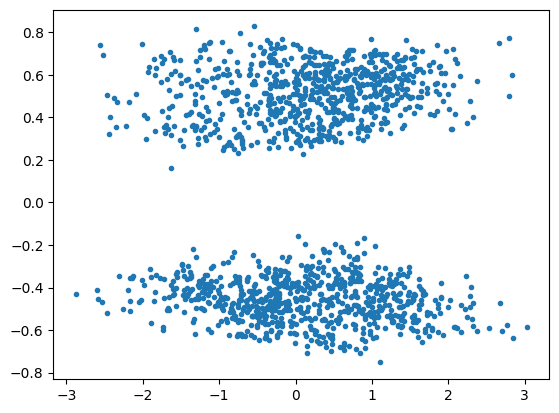

In [167]:
*xts, x02 = samples(model, torch.exp(final_loss_sigma), batchsize=1500, gam=1, mu=0)
plot_batch(x02)

In [165]:
# Independent test

# Distribution test - x

# Distribution test - y

[28.75289535522461,
 28.52452278137207,
 28.58237075805664,
 28.479454040527344,
 28.550697326660156,
 28.490266799926758,
 28.357986450195312,
 28.42729377746582,
 28.222890853881836,
 28.216083526611328,
 27.960994720458984,
 28.067869186401367,
 28.052892684936523,
 27.965728759765625,
 27.963651657104492,
 28.01707649230957,
 27.945175170898438,
 28.016584396362305,
 27.927024841308594,
 27.874427795410156,
 27.7910099029541,
 28.0469970703125,
 28.089988708496094,
 27.878192901611328,
 27.836162567138672,
 27.90388298034668,
 27.88082504272461,
 27.982574462890625,
 27.837308883666992,
 27.95781707763672,
 27.921009063720703,
 27.897106170654297,
 27.695829391479492,
 27.839523315429688,
 27.831558227539062,
 27.837961196899414,
 27.704626083374023,
 27.63860511779785,
 27.878650665283203,
 27.943315505981445,
 28.002084732055664,
 27.863861083984375,
 27.838157653808594,
 27.89482307434082,
 27.876426696777344,
 27.670778274536133,
 27.67617416381836,
 27.886213302612305,
 27.713